In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [3]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"
          }    
        

## Create modified group flag

In [4]:
unique_low = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    unique_low[key] = np.array(val)
f.close()

unique_high = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    unique_high[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

First, create all of the possible arrays that might be used in constructing my modified group flag. In particular, this will mean having an array with [False, True, True, True, ...], then an array with [False, False, True, True,...] because we want the array to be true at every snapshot after the FIRST group infall has occured, but false beforehand. 

In [5]:
# let's try to be smart about this ~ 
infall_arrays = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')

Then, the array that we want to use as our modified group flag (which I will call 'PostInfall') can be pulled using infall_arrays[snapnum] with snapnum is the infall snapshot number. Then, I can create the new flag array by just masking out the infall_arrays using the 'InfallSnapshot' column.

In [6]:
# verify that array was created correctly 
# (sum of Infall Snapshot num + num of snapshots with infall true should be 100)
np.unique(unique_low['InfallSnapshot'] + np.sum(infall_arrays[unique_low['InfallSnapshot']],axis=1))

array([100])

In [7]:
unique_low["PostInfall"] = infall_arrays[unique_low['InfallSnapshot']]
unique_high["PostInfall"] = infall_arrays[unique_high['InfallSnapshot']]

# unique_low["Merge"] = infall_arrays[unique_low['InfallSnapshot']]

# Number of pairs

## Total # of pairs

In [8]:
# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair
zeroed_low = np.where(~np.isnan(unique_low['Separations']),unique_low['Separations'],0)
is_pair_low = (zeroed_low!=0)
num_pairs_low = np.sum(is_pair_low,axis=0)

# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair
zeroed_high = np.where(~np.isnan(unique_high['Separations']),unique_high['Separations'],0)
is_pair_high = (zeroed_high!=0)
num_pairs_high = np.sum(is_pair_high,axis=0)


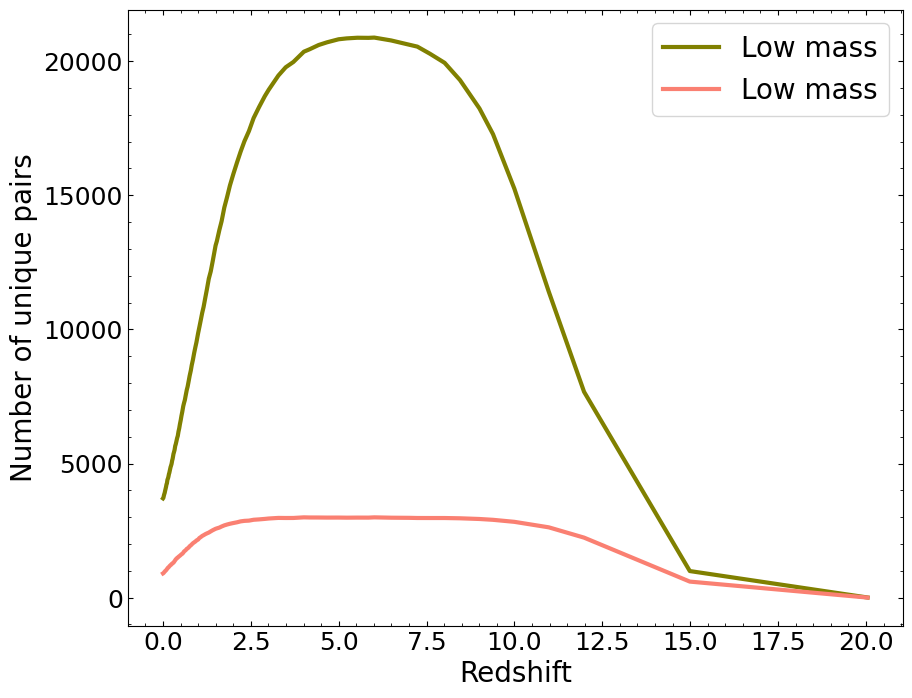

In [9]:

fig,ax = plt.subplots(figsize=(10,8))
plt.plot(convert["Redshift"],num_pairs_low,label='Low mass',color=palette['low'],lw=3)
plt.plot(convert["Redshift"],num_pairs_high,label='Low mass',color=palette['high'],lw=3)
# plt.plot(snap_dict["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:olive")
# plt.ylim(top=0.06)
# plt.xlim(right=10)
plt.legend()
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of unique pairs")
# plt.savefig("../../plots/bet-on-it/2_number-pairs-comp.png")
plt.show()

<font color='red'>Does the number of pairs at a given redshift need to change depending on the FoF group definition of a pair? 
    

## # of pairs w/ group info 

In [10]:
# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair
zeroed_low = np.where(~np.isnan(unique_low['Separations']),unique_low['Separations'],0)
is_pair_low = (zeroed_low!=0)
is_group_low = unique_low['GroupFlag']
is_post_low = unique_low['PostInfall']
num_pairs_low = np.sum(is_pair_low,axis=0)
num_grouped_low = np.sum(is_pair_low&is_group_low,axis=0)
num_post_low = np.sum(is_pair_low&is_post_low,axis=0)

# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair
zeroed_high = np.where(~np.isnan(unique_high['Separations']),unique_high['Separations'],0)
is_pair_high = (zeroed_high!=0)
is_group_high = unique_high['GroupFlag']
is_post_high = unique_high['PostInfall']
num_pairs_high = np.sum(is_pair_high,axis=0)
num_grouped_high = np.sum(is_pair_high&is_group_high,axis=0)
num_post_high = np.sum(is_pair_high&is_post_high,axis=0)



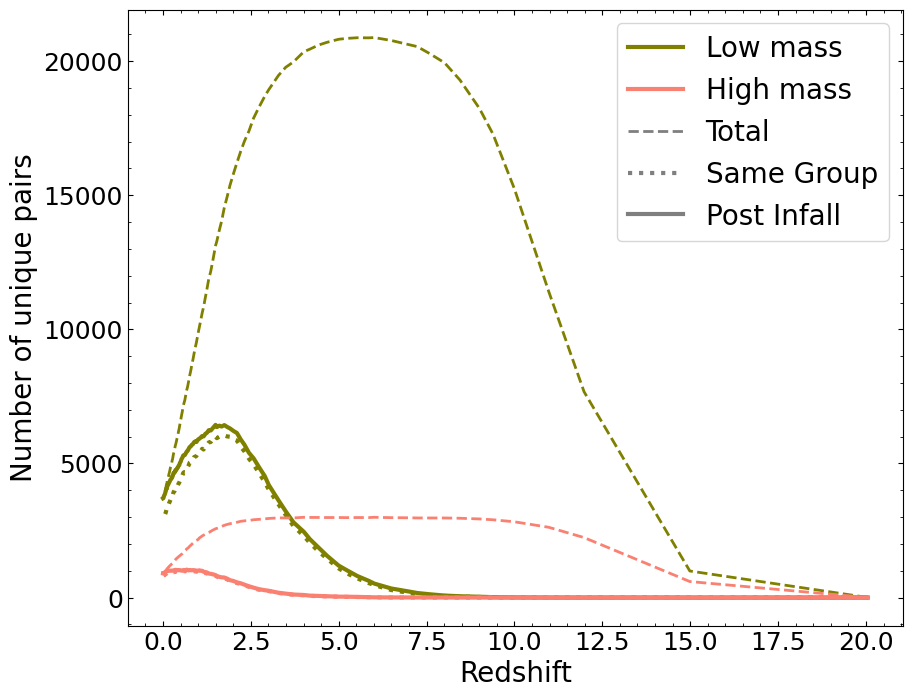

In [11]:

fig,ax = plt.subplots(figsize=(10,8))
plt.plot(convert["Redshift"],num_pairs_low,linestyle='dashed',color=palette['low'],lw=2)
plt.plot(convert["Redshift"],num_grouped_low,linestyle='dotted',color=palette['low'],lw=3)
plt.plot(convert["Redshift"],num_post_low,label='Low mass',color=palette['low'],lw=3)
plt.plot(convert["Redshift"],num_pairs_high,linestyle='dashed',color=palette['high'],lw=2)
plt.plot(convert["Redshift"],num_grouped_high,linestyle='dotted',color=palette['high'],lw=3)
plt.plot(convert["Redshift"],num_post_high,label='High mass',color=palette['high'],lw=3)

plt.plot(0,0,label='Total',linestyle='dashed',color="tab:grey",lw=2)
plt.plot(0,0,label='Same Group',linestyle='dotted',color="tab:grey",lw=3)
plt.plot(0,0,label='Post Infall',color="tab:grey",lw=3)

# plt.plot(snap_dict["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:olive")
# plt.ylim(top=0.06)
# plt.xlim(right=10)
plt.legend()
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of unique pairs")
# plt.savefig("../../plots/bet-on-it/2_number-pairs-detailed.png")
plt.show()

## # of pairs that have had 'infall'

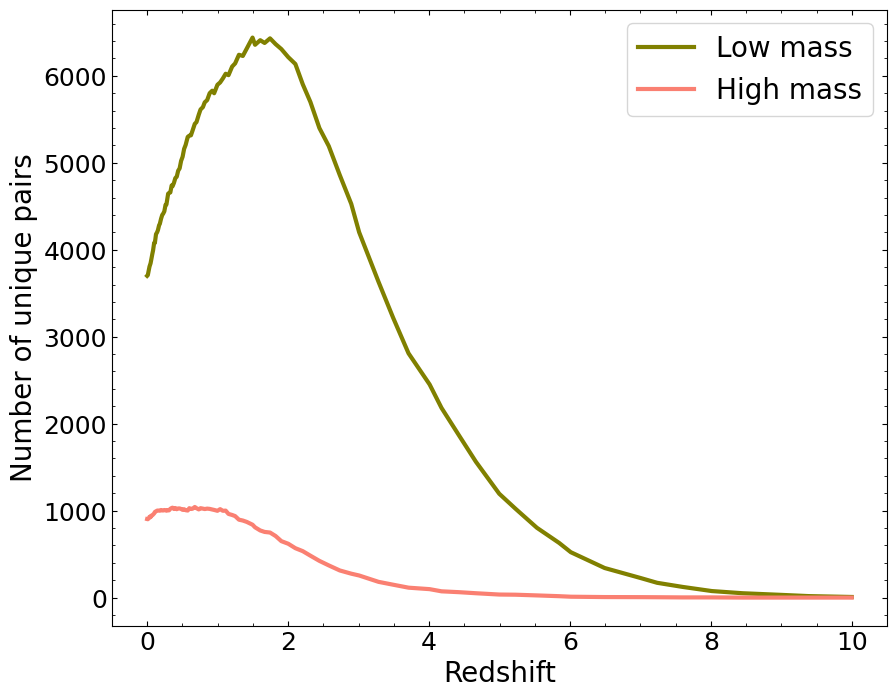

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
# plt.plot(convert["Redshift"],num_pairs_low,linestyle='dashed',color="tab:cyan",lw=2)
# plt.plot(convert["Redshift"],num_grouped_low,linestyle='dotted',color="tab:cyan",lw=3)
plt.plot(convert["Redshift"][4:],num_post_low[4:],label='Low mass',color=palette['low'],lw=3)
# plt.plot(convert["Redshift"],num_pairs_high,linestyle='dashed',color="tab:olive",lw=2)
# plt.plot(convert["Redshift"],num_grouped_high,linestyle='dotted',color="tab:olive",lw=3)
plt.plot(convert["Redshift"][4:],num_post_high[4:],label='High mass',color=palette['high'],lw=3)

# plt.plot(0,0,label='Total',linestyle='dashed',color="tab:grey",lw=2)
# plt.plot(0,0,label='Same Group',linestyle='dotted',color="tab:grey",lw=3)
# plt.plot(0,0,label='Post Infall',color="tab:grey",lw=3)

# plt.plot(snap_dict["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:olive")
# plt.ylim(top=0.06)
# plt.xlim(right=10)
plt.legend()
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of unique pairs")
plt.savefig("../../plots/bet-on-it/2_number-pairs-comp.pdf")
plt.show()


<font color='red'> add the number of pairs to each of the panels of the 2d histograms 


# Cumulative Time Spent [no interp]

In [13]:
high,low = {}, {}
for i in [33,40,50]:
    high[i] = {}
    f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        high[i][key] = np.array(val)
    f.close()
    
    low[i] = {}
    f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        low[i][key] = np.array(val)
    f.close()



In [14]:
def get_hist(data, convert, septype = "Separations", bin_array=np.arange(0,400,20), merger_only=True):
    """ . """
    sep_matrix = data["Separations"]
    bins = bin_array
    
    elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
    elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))
    
    infall_arrays = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')
    post_infall_matrix = infall_arrays[data['InfallSnapshot']]

    # build masks to remove low separation objects
    non_zero = sep_matrix != 0
    lower_sep = sep_matrix > 10
    non_nan = ~np.isnan(sep_matrix)

    matrix_mask = non_zero & lower_sep & non_nan

    merger_array = np.array(data["MergeFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(100,1)).transpose()
    
    if septype != "Separations":
        sep_matrix = data[septype]
    
    ## calculate histograms
    if merger_only:
        xx = sep_matrix[matrix_mask & merge_mask & post_infall_matrix]
        yy = elapsed_matrix[matrix_mask & merge_mask & post_infall_matrix]
        sample_size = sum(merger_array)
    else:
        xx = sep_matrix[matrix_mask & post_infall_matrix]
        yy = elapsed_matrix[matrix_mask & post_infall_matrix]
        sample_size = len(merger_array) 

    vals, bins = np.histogram(xx, bins=bins, weights=yy/sample_size)
    
    return vals, bins

### Distribution of separations prior to z

For z=2, pull out all of the pairs that have infallen by z=2 and see what their distribution of previous time at seps were

### Distribution of seps for all things that have merged by z

See what the total time spent at seps are for anything that merges before z=2 (so all merges before z=2, cumsum their time in bins, then do the same for all things that merge before z=1.5, etc.)


## Pull z=2, z=1.5, and z=1 as independent sets

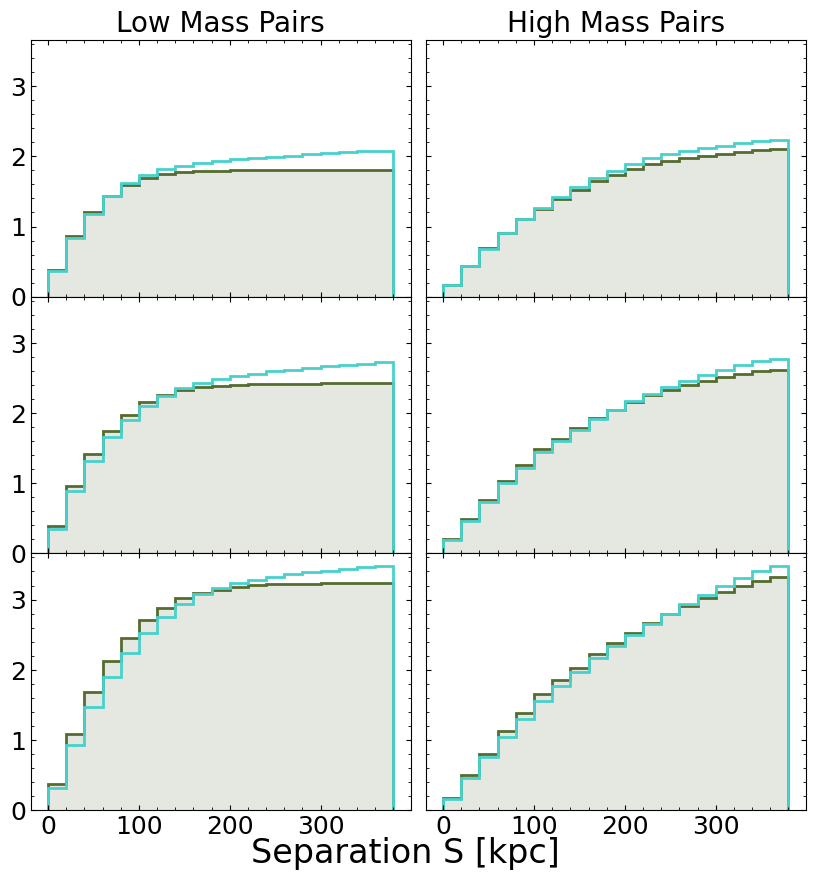

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for en,i in enumerate([low, high]):
    for ii, snap in enumerate([33, 40, 50]):
        orb = i[snap]
        sep_matrix = orb["Separations"]
        elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
        scales = convert['Scale'] # gives scale in same order as orbit data

        scale_matrix = np.tile(scales,(len(sep_matrix),1))
        sep_ckpcperh = sep_matrix/scale_matrix*little_h

        # array of the elapsed time with a nan value in the place of z=0
        elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
        elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

        nan_elapsed = np.isnan(elapsed_matrix)
        nan_sep = np.isnan(sep_matrix)
        zero_sep = sep_matrix == 0
        lower_sep = sep_ckpcperh > 10
        matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep

        merger_array = np.array(orb["MergeFlag"],dtype='bool')
        merge_mask = np.tile(merger_array,(100,1)).transpose()

    #     elapsed_masked = elapsed_matrix[matrix_mask]
    #     sep_masked = sep_matrix[matrix_mask]

        ## calculate histograms
        xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]


        xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

        yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

        num_mergers = sum(merger_array)
        num_pairs = len(merger_array) 
        bins_phys = np.arange(0,400,20)
        bins_ckpch = np.arange(10,300,20)

        phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
        phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
        comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
        comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    

        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2)
        ax[ii][en].stairs(np.cumsum(phys_all),bins_phys,color="mediumturquoise",lw=2,label='All Pairs')

#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2)
#         ax[ii][1].stairs(np.cumsum(comov_all),bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')

#         ax[ii][1].text(375,0.1,f"{z[str(snap)]}")


    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    #     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
    # #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")

    #     ax[ii].text(0,1,f"{z[str(snap)]}")
    #     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    #     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


    ax[0][0].set_title("Low Mass Pairs",fontsize=20)
    ax[0][1].set_title("High Mass Pairs",fontsize=20)

#     ax[2][0].set_xlabel("Separation [kpc]")
#     ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

#     ax[0][0].legend()
#     ax[0][1].legend()

#     ax[0][0].legend()
#     fig.suptitle("Total time with sep < S: Massive pairs")
    # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
    fig.supxlabel("Separation S [kpc]",y=0.05)
#     fig.supylabel(r"$\left< \Delta T\right>_{pair}$ where $r_{sep}<S$ [Gyr]")
#     plt.savefig(f"{paths.path_plots}big-bad/cumulative-timevssep_z.png")
plt.show()


## Scaled vs Not, Low vs High

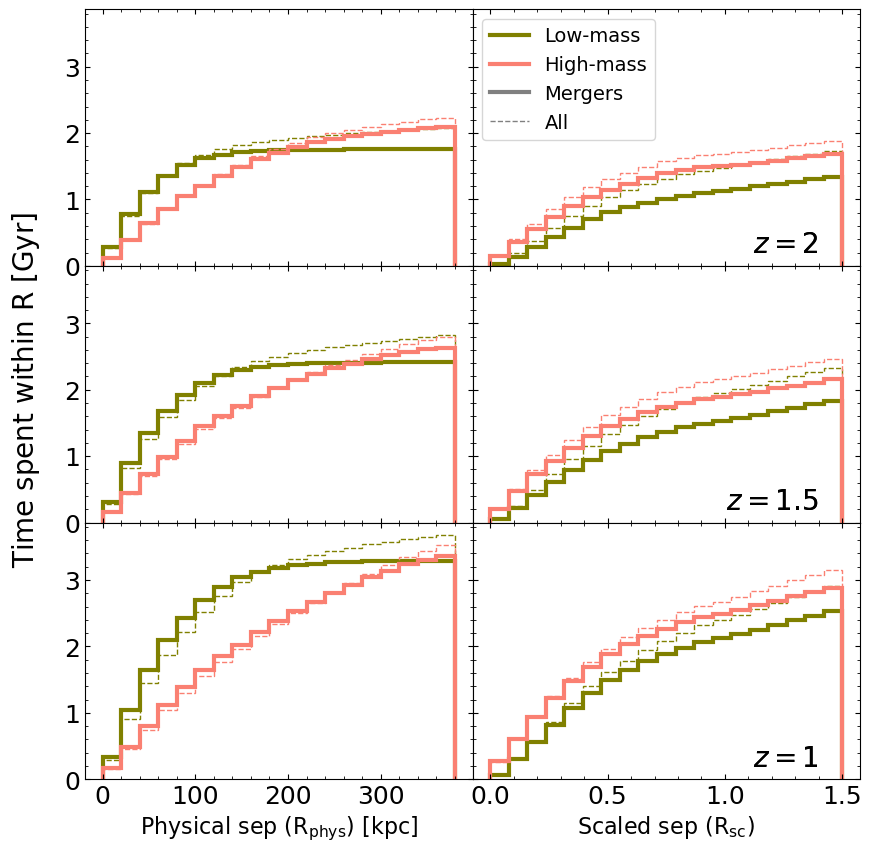

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_label = ["Low-mass","High-mass"]

for en,i in enumerate(data_sets):
    for ii, snap in enumerate([33, 40, 50]):
        vals, edges = get_hist(i[snap], convert)
        ax[ii][0].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=3,label=data_label[en])
        
        vals, edges = get_hist(i[snap], convert,merger_only=False)
        ax[ii][0].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],linestyle='dashed',lw=1)
        
        
        vals, edges = get_hist(i[snap], convert, septype="SeparationsScaled",bin_array=np.linspace(0,1.5,20))
        ax[ii][1].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=3,label=data_label[en])
        
        vals, edges = get_hist(i[snap], convert, septype="SeparationsScaled",bin_array=np.linspace(0,1.5,20),merger_only=False)
        ax[ii][1].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],linestyle='dashed',lw=1)
        
        ax[ii][1].text(1.4,0.2,z[str(snap)],ha='right')


ax[0][1].plot(0,0,color="grey",lw=3,label="Mergers")
ax[0][1].plot(0,0,color="grey",linestyle='dashed',lw=1,label="All")
ax[0][1].legend(loc='upper left',fontsize=14)

ax[2][0].set_xlabel(r"Physical sep $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[2][1].set_xlabel(r"Scaled sep $(\rm R_{sc})$",fontsize=16)
fig.supylabel(r"Time spent within $\rm R$ [Gyr]",x=0.05,fontsize=20)

plt.savefig(f"{paths.path_plots}bet-on-it/2_cumulatives_nointerp.pdf")
plt.show()



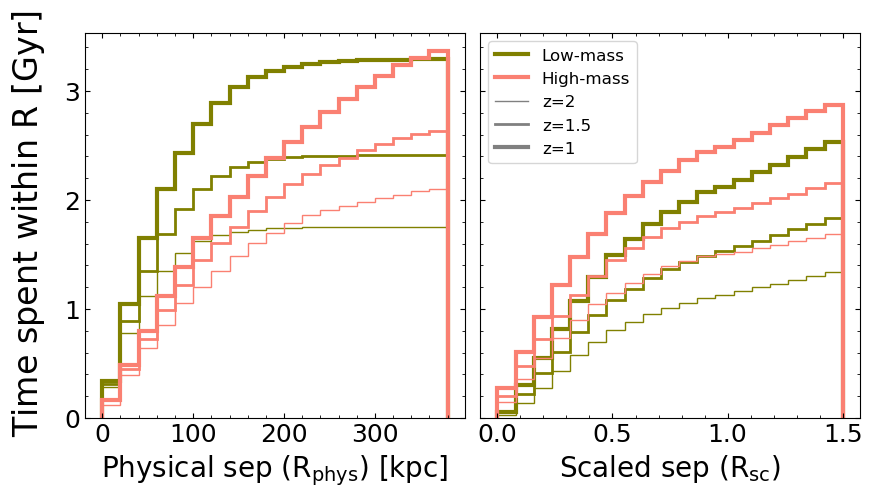

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,5),sharey=True, sharex='col', 
                       gridspec_kw={'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_label = ["Low-mass","High-mass"]

zs = [2,1.5,1]
snaps = [33, 40, 50]

for en,i in enumerate(data_sets):
    for ii, snap in enumerate(snaps):
        vals, edges = get_hist(i[snap], convert)
        ax[0].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=ii+1)
        
        vals, edges = get_hist(i[snap], convert, septype="SeparationsScaled",bin_array=np.linspace(0,1.5,20))
        ax[1].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=ii+1)
    ax[1].plot(0,0,color=palette[data_name[en]],lw=ii+1,label=data_label[en])
    
for j in range(3):
    ax[1].plot(0,0, color="grey", lw=j+1, label=f"z={zs[j]}")
ax[1].legend(fontsize=12)

ax[0].set_xlabel(r"Physical sep $(\rm R_{phys})$ [kpc]")
ax[1].set_xlabel(r"Scaled sep $(\rm R_{sc})$")
fig.supylabel(r"Time spent within $\rm R$ [Gyr]",x=0.05)

# plt.savefig(f"{paths.path_plots}bet-on-it/2_cumulatives.png")
plt.show()



# Cumulative time w interp

In [18]:
high,low = {}, {}
for i in [33,40,50]:
    high[i] = {}
    f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        high[i][key] = np.array(val)
    f.close()
    
    low[i] = {}
    f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        low[i][key] = np.array(val)
    f.close()



In [19]:
def create_interp(data, convert, num_samples=10000):
    # first, create interpolated conversion file so I have a list of redshifts and lookback times
    convert_interp = {}
    convert_interp["Lookback Time Interp"] = np.linspace(convert['Lookback Time'][0],convert['Lookback Time'][-1],num_samples)

    # interpolating Redshift along with Lookback Time:
    convert_interp["Redshift Interp"] = np.interp(convert_interp["Lookback Time Interp"][::-1], xp=convert['Lookback Time'][::-1], fp=convert['Redshift'][::-1])[::-1]

    # define the times that I am inputing with the data, and the interpolated 
    # time array where the interpolated data is returned
    times = convert['Lookback Time'][::-1]
    times_interp = convert_interp["Lookback Time Interp"][::-1]
    
    interp_dict = data.copy()
    interp_dict['Separations Interp'] = (np.zeros((len(data['Separations']),num_samples)))
    interp_dict['Separations Interp'].fill(np.nan)
    interp_dict['SeparationsComoving Interp'] = np.zeros((len(data['SeparationsComoving']),num_samples))
    interp_dict['SeparationsComoving Interp'].fill(np.nan)
    interp_dict['SeparationsScaled Interp'] = np.zeros((len(data['SeparationsScaled']),num_samples))
    interp_dict['SeparationsScaled Interp'].fill(np.nan)

    # complete interpolation of all separation values for each pair individually 
    # note that np.interp requires monotonically increasing x, hence the [::-1]
    for i in range(len(data['PairKey'])):
        seps = data['Separations'][i][::-1]
        comov = data['SeparationsComoving'][i][::-1]
        scaled = data['SeparationsScaled'][i][::-1]

        seps_interp = np.interp(times_interp, xp=times, fp=seps)[::-1]
        comov_interp = np.interp(times_interp, xp=times, fp=comov)[::-1]
        scale_interp = np.interp(times_interp, xp=times, fp=scaled)[::-1]

        interp_dict['Separations Interp'][i,:] = seps_interp
        interp_dict['SeparationsComoving Interp'][i,:] = comov_interp
        interp_dict['SeparationsScaled Interp'][i,:] = scale_interp
        
    
    return interp_dict, convert_interp


In [20]:
high_interp = {}
low_interp = {}

for i in [33, 40, 50]:
    high_interp[i], _ = create_interp(high[i], convert)
    low_interp[i], convert_interp = create_interp(low[i], convert)

### create arrays that allow for the conversion between the interpolated and non-interpolated tables

In [21]:
ind_in_convert = []
for i in convert_interp['Lookback Time Interp']:
    ind_in_convert.append(np.where((i - convert["Lookback Time"])<=0)[0][-1])
   
ind_in_convert = np.array(ind_in_convert)
_, ind_in_interp = np.unique(ind_in_convert,return_index=True)

In [22]:
infall_interp = np.array(np.triu(np.zeros((len(convert_interp['Lookback Time Interp']),len(convert_interp['Lookback Time Interp'])))+1),dtype='bool')
infall = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')


In [23]:
test_num = np.random.randint(100)
infall[test_num] == infall_interp[ind_in_interp[test_num]][ind_in_interp]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Since the array above is all true, that means that we have created a way of indexing into the infall table correctly and assigning the correct infall array to each pair! ~~~ 

Now, let's create the post_infall_matrix, which will be of size (len(data),10000)

### Create the post infall matrix that corresponds to the interpolated separation array 

In [24]:
# we have the data for the infall snapshot
low[33]['InfallSnapshot']

array([31, 33, 31, ..., 25, 30, 27], dtype=int32)

In [25]:
# corresponding index that we'll want from the infall table
ind_in_interp[low[33]['InfallSnapshot']]

array([2056, 2280, 2056, ..., 1444, 1952, 1618])

In [26]:
post_infall_matrix = infall_interp[ind_in_interp[low[33]['InfallSnapshot']]]

check that a random index of the the post infall matrix contains the correct infall snapshot array

In [27]:
check = 128

post_infall_matrix[14][ind_in_interp] == infall[low[33]['InfallSnapshot'][14]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

if the array above is fully true, it means that we've pulled out the correct "has this pair infallen yet" array, and that it correctly corresponds to the snapshot at which infall occured (and the corresponding lookback time)

## Create function to get the interpolated histogram data

In [28]:
def get_hist_interp(data, convert, septype = "Separations Interp", bin_array=np.arange(0,400,20), merger_only=True):
    """ . """
    sep_matrix = data["Separations Interp"]
    bins = bin_array
    
    elapsed_time = np.abs(np.diff(convert["Lookback Time Interp"]))
    elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))
    
    infall_interp = np.array(np.triu(np.zeros((len(elapsed_noz0),len(elapsed_noz0)))+1),dtype='bool')
    post_infall_matrix = infall_interp[ind_in_interp[data['InfallSnapshot']]]

    # build masks to remove low separation objects
    lower_sep = sep_matrix > 10
    non_nan = ~np.isnan(sep_matrix)

    matrix_mask = lower_sep & non_nan

    merger_array = np.array(data["MergeFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(len(elapsed_noz0),1)).transpose()
    
    if septype != "Separations Interp":
        sep_matrix = data[septype]
    
    ## calculate histograms
    if merger_only:
        xx = sep_matrix[matrix_mask & merge_mask & post_infall_matrix]
        yy = elapsed_matrix[matrix_mask & merge_mask & post_infall_matrix]
        sample_size = sum(merger_array)
    else:
        xx = sep_matrix[matrix_mask & post_infall_matrix]
        yy = elapsed_matrix[matrix_mask & post_infall_matrix]
        sample_size = len(merger_array) 

    vals, bins = np.histogram(xx, bins=bins, weights=yy/sample_size)
    
    return vals, bins

In [29]:
low_interp[40]['Separations Interp'].shape

(1330, 10000)

In [30]:
vals, edges = get_hist_interp(low_interp[40],convert_interp)


In [31]:
vals

array([2.96552488e-01, 5.70437596e-01, 4.40993213e-01, 3.18919624e-01,
       2.22779722e-01, 1.66830606e-01, 1.07278548e-01, 7.30346639e-02,
       4.14873011e-02, 2.47622744e-02, 1.61233989e-02, 8.46828159e-03,
       2.12218821e-03, 1.45914656e-03, 1.69342886e-03, 1.51601120e-03,
       5.75470116e-04, 1.39887004e-04, 1.56946395e-04])

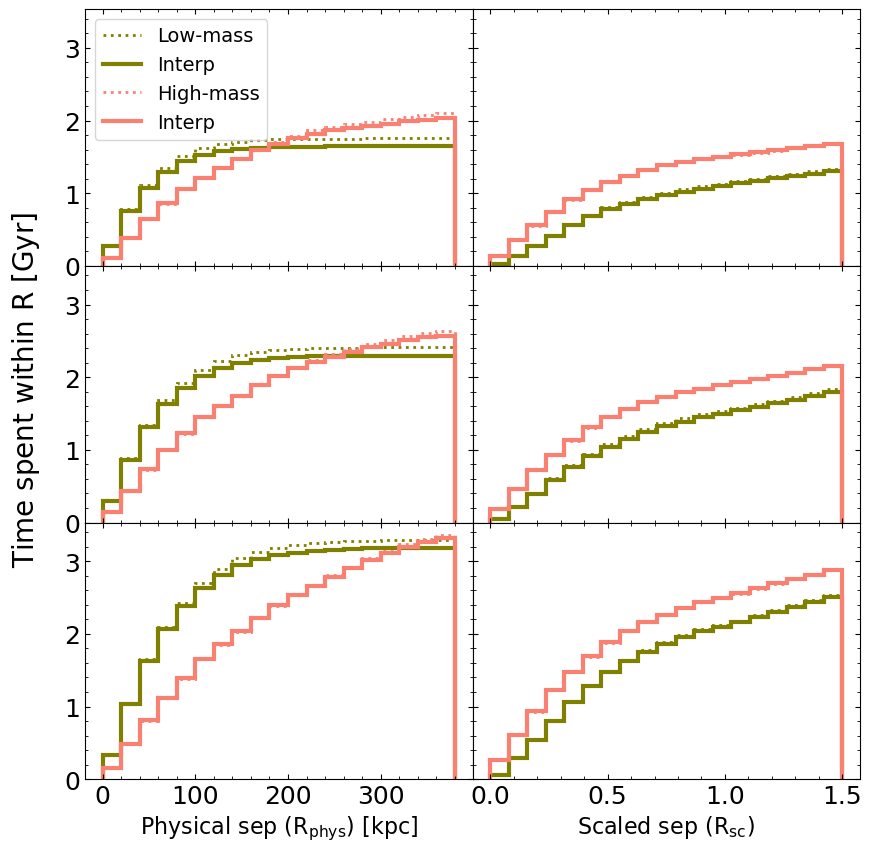

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]

for en in range(2):
    for ii, snap in enumerate([33, 40, 50]):
        vals, edges = get_hist(data_sets[en][snap], convert)
        ax[ii][0].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],linestyle='dotted',lw=2,label=data_label[en])
        
        vals, edges = get_hist_interp(data_sets_interp[en][snap], convert_interp)
        ax[ii][0].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=3,label="Interp")
        
        vals, edges = get_hist(data_sets[en][snap], convert, septype="SeparationsScaled",bin_array=np.linspace(0,1.5,20))
        ax[ii][1].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],linestyle='dotted',lw=2,label=data_label[en])
        
        vals, edges = get_hist_interp(data_sets_interp[en][snap], convert_interp, septype="SeparationsScaled Interp",bin_array=np.linspace(0,1.5,20))
        ax[ii][1].stairs(np.cumsum(vals),edges,color=palette[data_name[en]],lw=3,label="Interp")
        
      
        
#         ax[ii][1].text(1.4,0.2,z[str(snap)],ha='right')


ax[0][1].plot(0,0,color="grey",lw=3,label="Mergers")
ax[0][1].plot(0,0,color="grey",linestyle='dashed',lw=1,label="All")
ax[0][0].legend(loc='upper left',fontsize=14)

ax[2][0].set_xlabel(r"Physical sep $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[2][1].set_xlabel(r"Scaled sep $(\rm R_{sc})$",fontsize=16)
fig.supylabel(r"Time spent within $\rm R$ [Gyr]",x=0.05,fontsize=20)

# plt.savefig(f"{paths.path_plots}bet-on-it/2_cumulatives_nointerp.png")
plt.show()



# Manual cumulative plots 
plotting mean + std and median + quartiles

In [33]:
def get_manual_cumulative(data, convert, interp=False, scaled=False, merger_only=True, bin_array=np.arange(0,440,20)):
    """ . """
   
    if interp:
        sep_matrix = data["Separations Interp"]
        lookback_times = convert["Lookback Time Interp"]
        elapsed_time = np.abs(np.diff(lookback_times))
        infall_arrays = np.array(np.triu(np.zeros((len(lookback_times),len(lookback_times)))+1),dtype='bool')
        post_infall_matrix = infall_arrays[ind_in_interp[data['InfallSnapshot']]]
        
    else:
        sep_matrix = data["Separations"]
        lookback_times = convert["Lookback Time"]
        elapsed_time = np.abs(np.diff(lookback_times))
        infall_arrays = np.array(np.triu(np.zeros((len(lookback_times),len(lookback_times)))+1),dtype='bool')
        post_infall_matrix = infall_arrays[data['InfallSnapshot']]

    elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1)) 

    # build masks to remove low separation objects
    lower_sep = sep_matrix > 10
    non_nan = ~np.isnan(sep_matrix)

    matrix_mask = lower_sep & non_nan
    
    merger_array = np.array(data["MergeFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(len(elapsed_noz0),1)).transpose()
    
    septype = "Separations"
    
#     bin_array=np.arange(0,440,20)
#     bin_array=np.arange(0,340,10)
    
    if scaled:
        septype = septype+"Scaled"
#         bin_array=np.linspace(0,2.1,20)
        bin_array = np.arange(0,2.2,0.1)

    if interp:
        septype = septype+" Interp"

    sep_matrix = data[septype]
    
    ## calculate histograms
    if merger_only:
        sep_masked = np.where((matrix_mask&merge_mask&post_infall_matrix),sep_matrix,0)

    else:
        sep_masked = np.where((matrix_mask&post_infall_matrix), sep_matrix, 0)

    mean, std = [], []
    med,qs = [], []
    
    for i in range(len(bin_array)-1):
        # give the elapsed matrix array where the separations are between 10-bin[i+1]
        what = np.where(sep_masked > 0 ,np.where(sep_masked < bin_array[i+1], elapsed_matrix,False),False)
        sums = np.sum(what,axis=1)
        mean.append(np.mean(sums))
        std.append(np.std(sums))
        med.append(np.median(sums))
        qs.append(np.quantile(sums,np.array([0.25,0.75])))

#         print(np.mean(sums), np.std(sums), np.median(sums), np.quantile(sums,np.array([0.25,0.75])))
    
    return np.array(mean), np.array(std), np.array(med), np.array(qs), bin_array
        
        
        

In [34]:
np.arange(0,2.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [35]:
ms, ss, mds, qs, bins = get_manual_cumulative(low[33], convert, interp=False, scaled=False, merger_only=True)

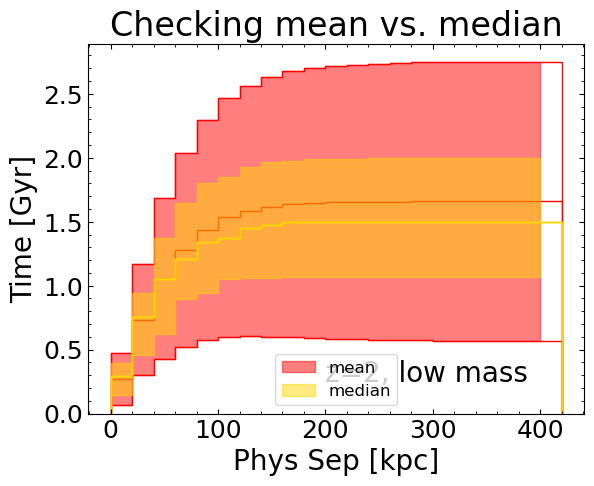

In [36]:
plt.fill_between(bins[:-1],ms-ss,ms+ss,step='post',color='red',alpha=0.5,label='mean')
plt.stairs(ms,edges=bins,color='red')
plt.stairs(ms-ss,edges=bins,color='red')
plt.stairs(ms+ss,edges=bins,color='red')

plt.stairs(mds,edges=bins,color='gold')
plt.stairs(mds,edges=bins,color='gold')
plt.stairs(mds,edges=bins,color='gold')
plt.fill_between(bins[:-1],qs[:,0],qs[:,1],color='gold',step='post',alpha=0.5,label='median')
plt.title("Checking mean vs. median")
plt.ylabel("Time [Gyr]")
plt.xlabel("Phys Sep [kpc]")
plt.text(200,0.25,"z=2, low mass")


plt.legend(fontsize=12)
plt.show()

## Low vs high mass

### Non-interpolated

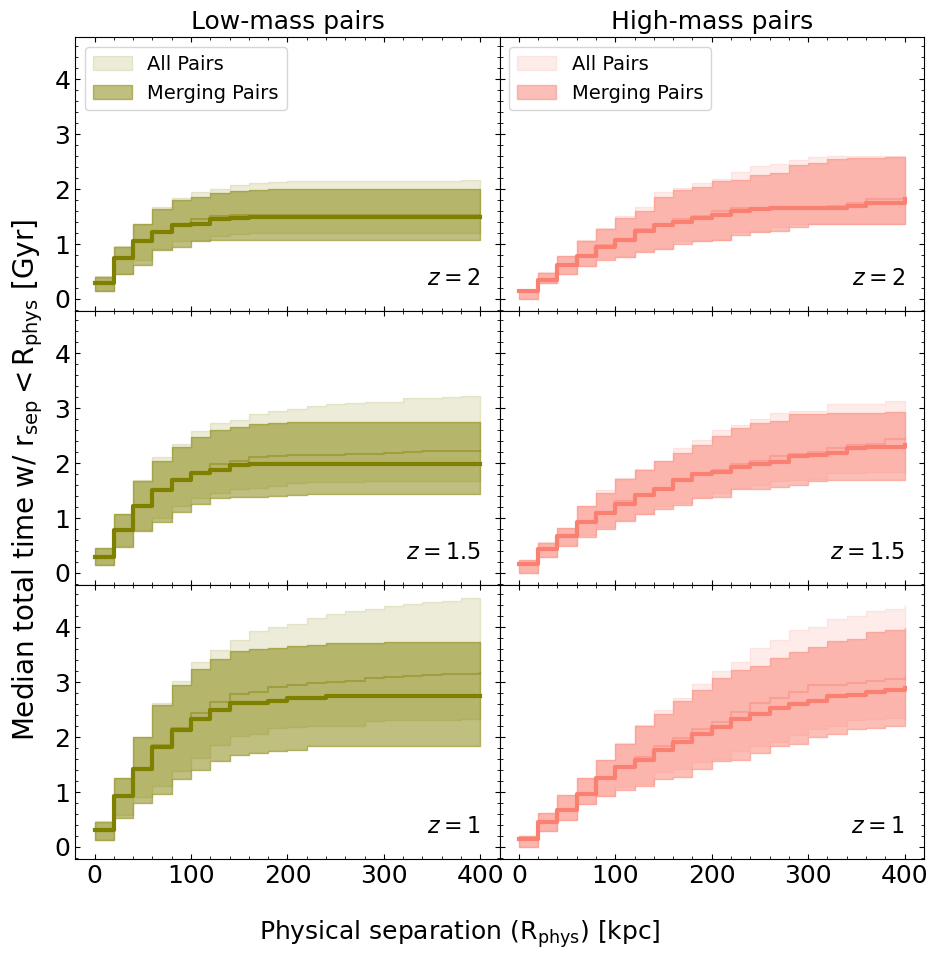

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]

for en in range(2):
    for ii, snap in enumerate([33, 40, 50]):
        # all pairs - mergers + non-mergers
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=False, merger_only=False)
        ax[ii][en].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',alpha=0.4)
        ax[ii][en].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.15,label="All Pairs")

        # merging pairs only
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=False, merger_only=True)        
        ax[ii][en].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][en].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label="Merging Pairs")

        ax[ii][en].text(400, 0.25, z[str(snap)], ha='right',fontsize=16)
# legend
ax[0][0].legend(loc='upper left',fontsize=14)
ax[0][1].legend(loc='upper left',fontsize=14)

# column titles
ax[0][0].set_title("Low-mass pairs",fontsize=18)
ax[0][1].set_title("High-mass pairs",fontsize=18)


fig.supxlabel(r"Physical separation $(\rm R_{phys})$ [kpc]",fontsize=18,y=0.03)
fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

plt.tight_layout()
# plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_LoHi_noint.png")
plt.show()



### Interpolated

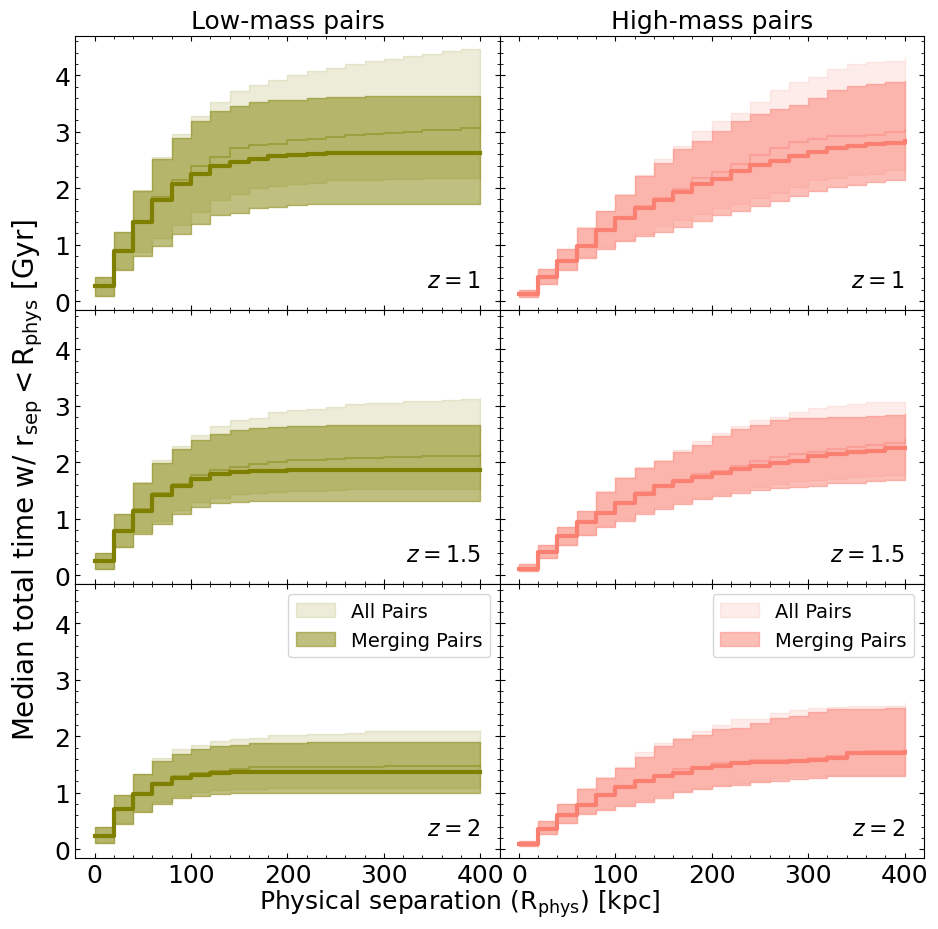

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]

for en in range(2):
    for ii, snap in enumerate([33, 40, 50][::-1]):
        # all pairs - mergers + non-mergers
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=False, merger_only=False)
        ax[ii][en].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',alpha=0.4)
        ax[ii][en].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.15,label="All Pairs")

        # merging pairs only
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=False, merger_only=True)        
        ax[ii][en].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][en].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label="Merging Pairs")

        ax[ii][en].text(400, 0.25, z[str(snap)], ha='right',fontsize=16)
# legend
ax[2][0].legend(loc='upper right',fontsize=14)
ax[2][1].legend(loc='upper right',fontsize=14)

# column titles
ax[0][0].set_title("Low-mass pairs",fontsize=18)
ax[0][1].set_title("High-mass pairs",fontsize=18)


fig.supxlabel(r"Physical separation $(\rm R_{phys})$ [kpc]",fontsize=18,y=0.06)
fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

plt.tight_layout()
plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_LoHi.pdf")
plt.show()



## Physical vs scaled

### Non-interpolated

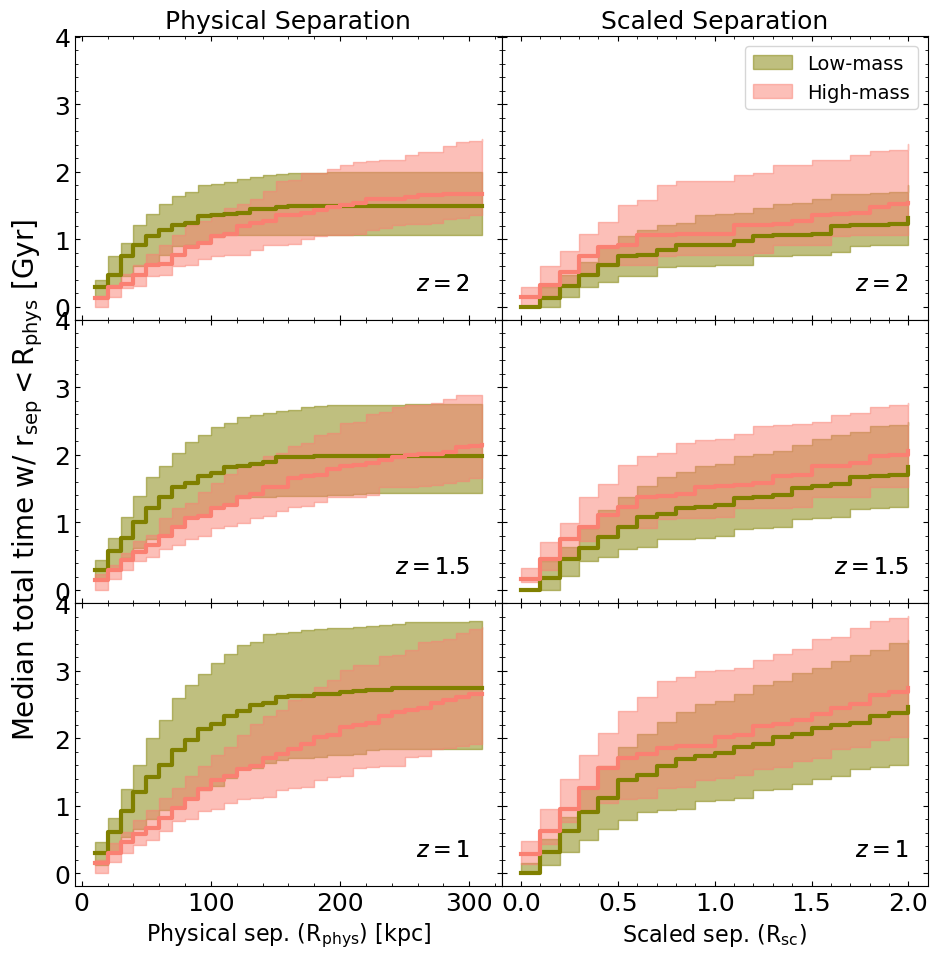

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,330,10)

for en in range(2):
    for ii, snap in enumerate([33, 40, 50]):
        # physical separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=False, merger_only=True,bin_array=bin_array)
        ax[ii][0].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][0].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[ii][0].text(300, 0.25, z[str(snap)], ha='right',fontsize=16)


        # scaled separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=True, merger_only=True,bin_array=bin_array)
        ax[ii][1].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][1].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[ii][1].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

# legend
# ax[0][0].legend(loc='upper left',fontsize=14)
ax[0][1].legend(loc='upper right',fontsize=14)

# column titles
ax[0][0].set_title("Physical Separation",fontsize=18)
ax[0][1].set_title("Scaled Separation",fontsize=18)


ax[2][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[2][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

plt.tight_layout()
# plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_PhSc_noint.png")
plt.show()



#### transpose

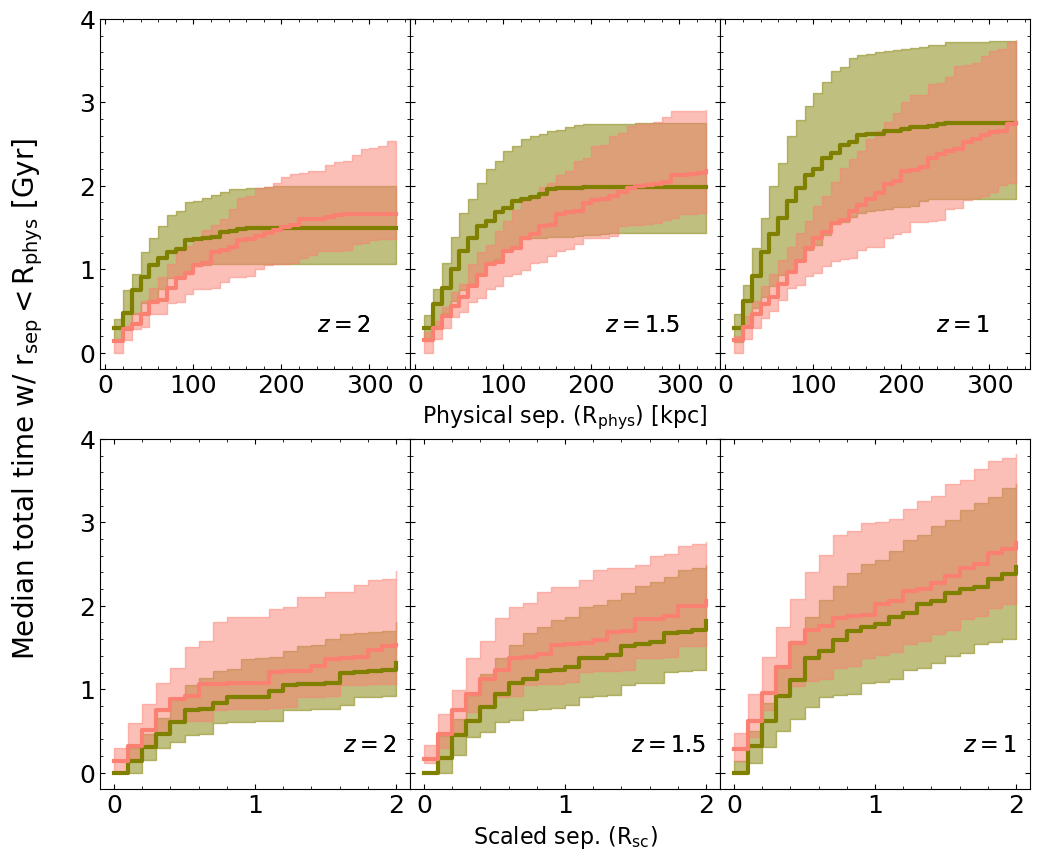

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(12,10),sharey=True, sharex='row', 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.0,
                                    "hspace":0.2})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,350,10)

for en in range(2):
    for ii, snap in enumerate([33, 40, 50]):
        # physical separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=False, merger_only=True,bin_array=bin_array)
        ax[0][ii].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[0][ii].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[0][ii].text(300, 0.25, z[str(snap)], ha='right',fontsize=16)


        # scaled separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets[en][snap], convert, interp=False, scaled=True, merger_only=True,bin_array=bin_array)
        ax[1][ii].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[1][ii].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[1][ii].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

# legend
# ax[0][0].legend(loc='upper left',fontsize=14)
# ax[0][1].legend(loc='upper right',fontsize=14)

# # column titles
# ax[0][0].set_title("Physical Separation",fontsize=18)
# ax[0][1].set_title("Scaled Separation",fontsize=18)


ax[0][1].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

# ax[0][0].set_yticks(minor=True)

fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

# plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_PhScT_noint.png")
plt.show()



### Interpolated

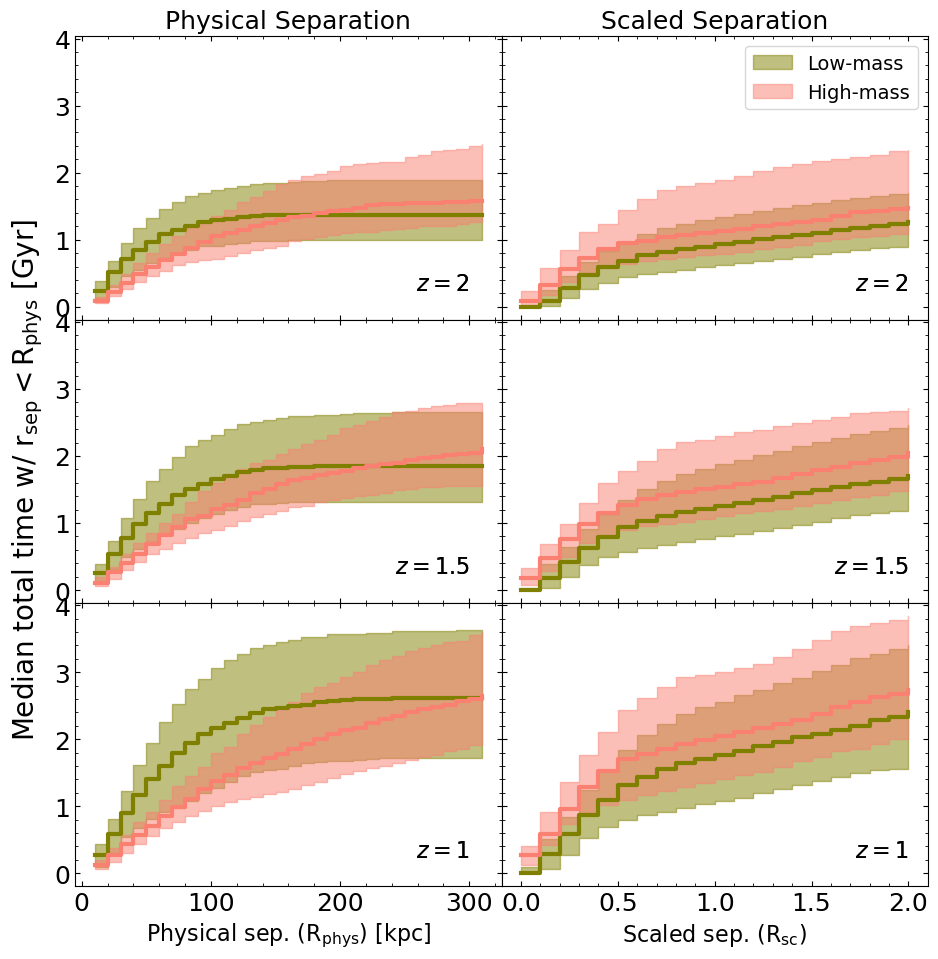

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,330,10)

for en in range(2):
    for ii, snap in enumerate([33, 40, 50]):
        # physical separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=False, merger_only=True,bin_array=bin_array)
        ax[ii][0].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][0].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[ii][0].text(300, 0.25, z[str(snap)], ha='right',fontsize=16)


        # scaled separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=True, merger_only=True,bin_array=bin_array)
        ax[ii][1].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[ii][1].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[ii][1].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

# legend
# ax[0][0].legend(loc='upper left',fontsize=14)
ax[0][1].legend(loc='upper right',fontsize=14)

# column titles
ax[0][0].set_title("Physical Separation",fontsize=18)
ax[0][1].set_title("Scaled Separation",fontsize=18)


ax[2][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[2][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

plt.tight_layout()
plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_PhSc.pdf")
plt.show()



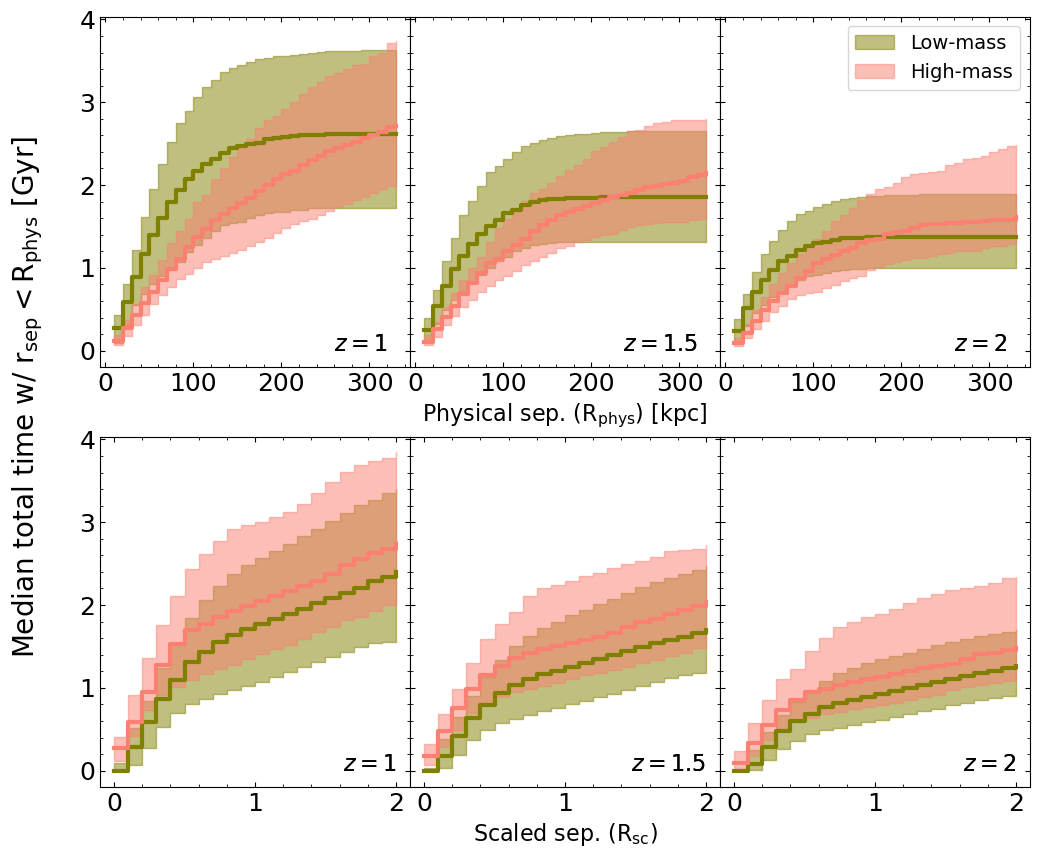

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(12,10),sharey=True, sharex='row', 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.0,
                                    "hspace":0.2})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,350,10)

for en in range(2):
    for ii, snap in enumerate([33, 40, 50][::-1]):
        # physical separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=False, merger_only=True,bin_array=bin_array)
        ax[0][ii].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[0][ii].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[0][ii].text(320, 0, z[str(snap)], ha='right',fontsize=16)


        # scaled separation
        ms, ss, mds, qs, bins = get_manual_cumulative(data_sets_interp[en][snap], convert_interp, interp=True, scaled=True, merger_only=True,bin_array=bin_array)
        ax[1][ii].plot(bins[:-1],mds,color=palette[data_name[en]],ds='steps-post',lw=3)
        ax[1][ii].fill_between(bins[:-1],qs[:,0],qs[:,1],color=palette[data_name[en]],step='post',alpha=0.5,label=data_label[en])
        
        ax[1][ii].text(2, 0, z[str(snap)], ha='right',fontsize=16)

# legend
# ax[0][0].legend(loc='upper left',fontsize=14)
ax[0][2].legend(loc='upper right',fontsize=14)

# # column titles
# ax[0][0].set_title("Physical Separation",fontsize=18)
# ax[0][1].set_title("Scaled Separation",fontsize=18)


ax[0][1].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

fig.supylabel(r"Median total time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",x=0.05,fontsize=20)

# plt.tight_layout()
plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_PhScT.pdf")
plt.show()



## Difference plots

### per snapshot

#### Non-interpolated

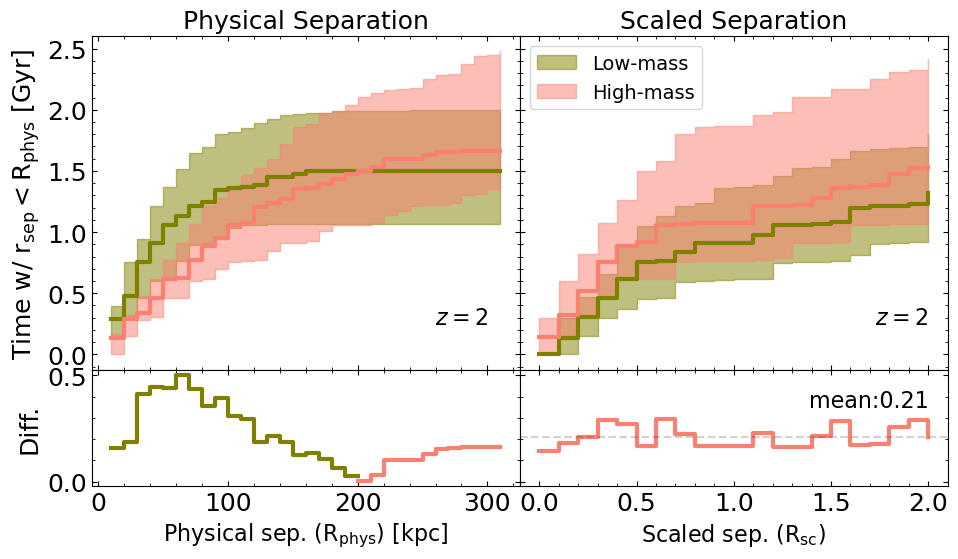

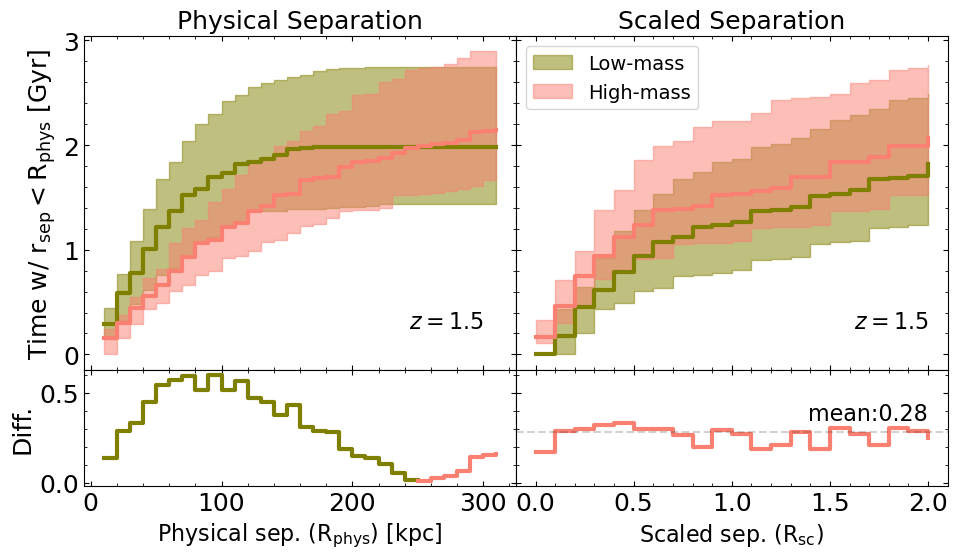

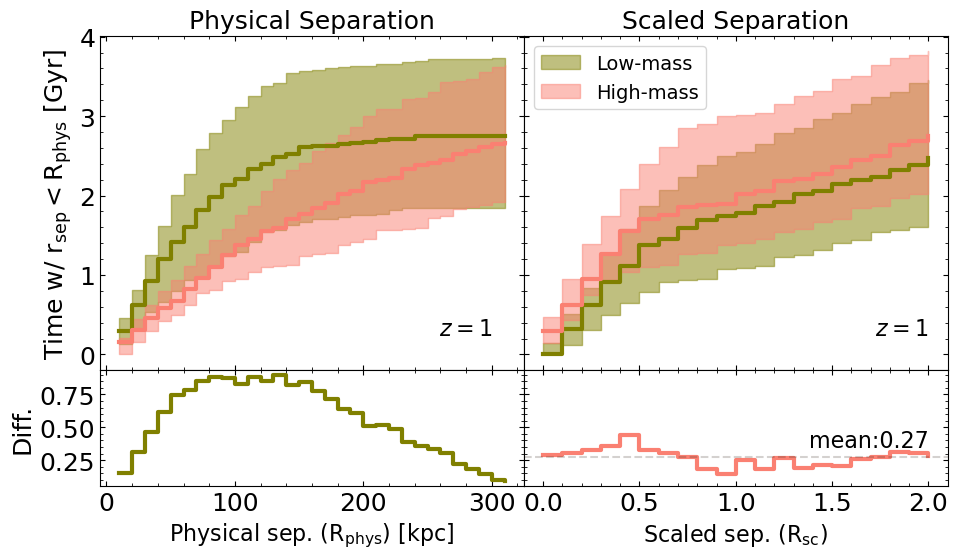

In [43]:
for i in [33, 40, 50]:

    fig, ax = plt.subplots(2, 2, figsize=(10,6),sharey='row', sharex='col', 
                           gridspec_kw={'width_ratios': [1,1], 
                                        'height_ratios':[1,0.35],
                                        'wspace': 0.0,
                                        "hspace":0.0})
    z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
    little_h = 0.6774
    data_name = ["low","high"]
    data_sets = [low,high]
    data_sets_interp = [low_interp,high_interp]
    data_label = ["Low-mass","High-mass"]
    secondary_name = ["difference","difference2"]
    secondary_name = ["All pairs","difference2"]
    bin_array = np.arange(10,330,10)
    snap = i

    ##########
    # Physical 
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low[snap], convert, interp=False, scaled=False, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high[snap], convert, interp=False, scaled=False, merger_only=True, bin_array=bin_array)      

    # plot 1 - physical LoHi
    ax[0][0].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][0].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][0].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][0].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])

    ax[0][0].text(300, 0.25, z[str(snap)], ha='right',fontsize=16)

    # plot 2 - difference phys
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][0].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][0].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)


    ########
    # Scaled 
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low[snap], convert, interp=False, scaled=True, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high[snap], convert, interp=False, scaled=True, merger_only=True, bin_array=bin_array) 

    # plot 1 - scaled LoHi
    ax[0][1].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][1].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][1].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][1].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])

    ax[0][1].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)
    
    # plot 2 - difference scaled
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][1].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][1].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)

    # ax[1][1].axhline(np.mean(high_dom)) 
    ax[1][1].axhline(np.median(high_dom),color=palette['difference'],alpha=0.2,linestyle='dashed') 
    ax[1][1].text(2, 0.35, f"mean:{np.median(high_dom):0.2f}", ha='right',fontsize=16)

    


    # legend
    # ax[0][0].legend(loc='upper left',fontsize=14)
    ax[0][1].legend(loc='upper left',fontsize=14)

    # column titles
    ax[0][0].set_title("Physical Separation",fontsize=18)
    ax[0][1].set_title("Scaled Separation",fontsize=18)

    # x labels
    ax[1][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
    ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

    # y labels
    ax[0][0].set_ylabel(r"Time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",fontsize=18)
    ax[1][0].set_ylabel("Diff.",fontsize=18)

    plt.tight_layout()
#     plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_diff_{snap}_noint.png")
    plt.show()




#### Interpolated

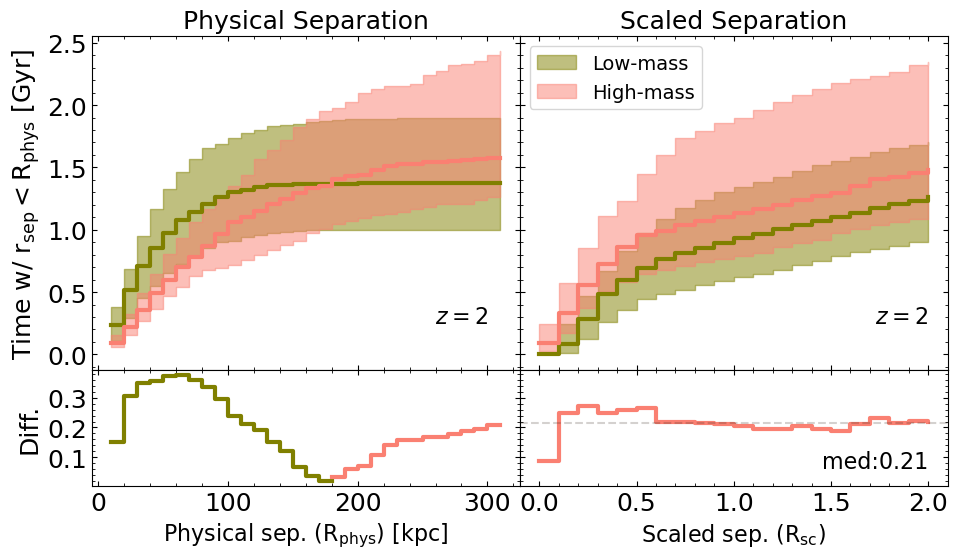

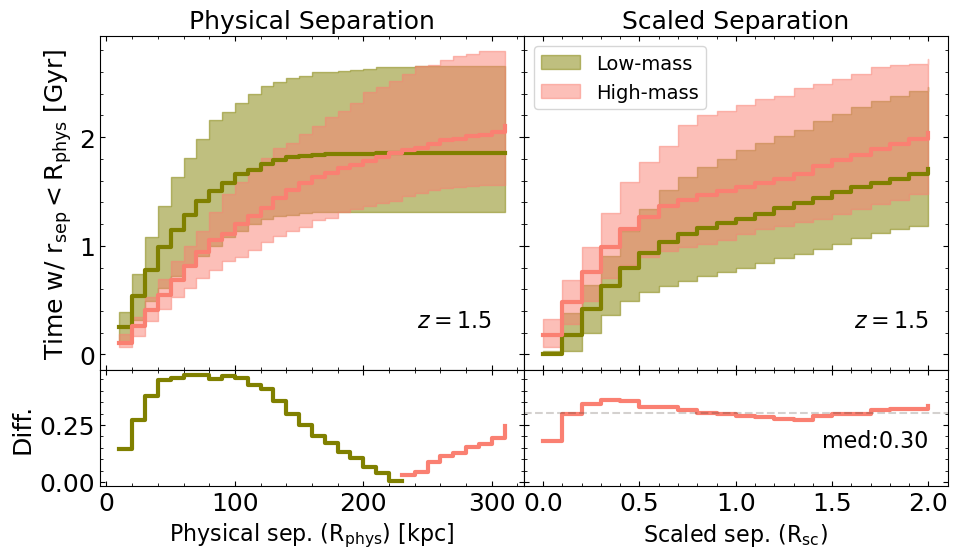

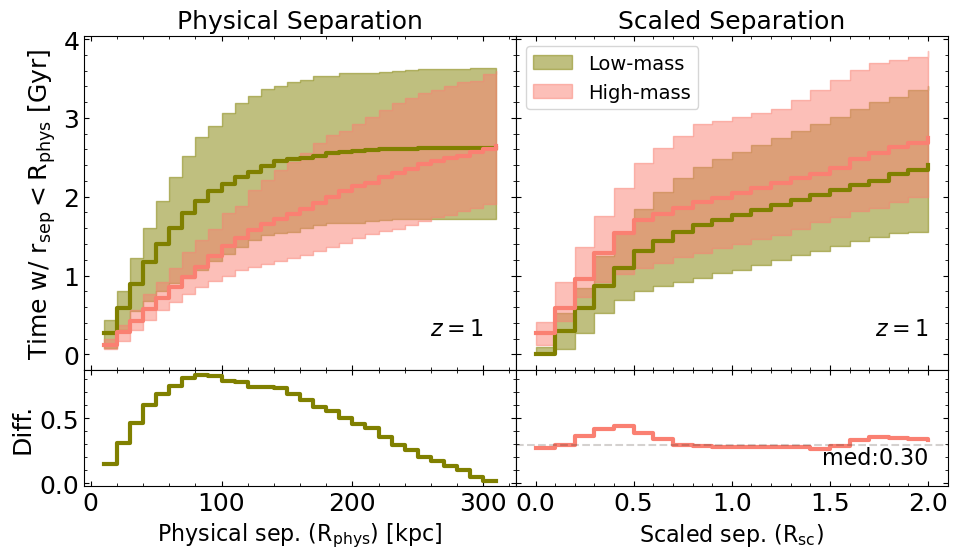

In [44]:
for i in [33, 40, 50]:

    fig, ax = plt.subplots(2, 2, figsize=(10,6),sharey='row', sharex='col', 
                           gridspec_kw={'width_ratios': [1,1], 
                                        'height_ratios':[1,0.35],
                                        'wspace': 0.0,
                                        "hspace":0.0})
    z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
    little_h = 0.6774
    data_name = ["low","high"]
    data_sets = [low,high]
    data_sets_interp = [low_interp,high_interp]
    data_label = ["Low-mass","High-mass"]
    secondary_name = ["difference","difference2"]
    secondary_name = ["All pairs","difference2"]
    bin_array = np.arange(10,330,10)
    snap = i

    ##########
    # Physical 
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low_interp[snap], convert_interp, interp=True, scaled=False, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high_interp[snap], convert_interp, interp=True, scaled=False, merger_only=True, bin_array=bin_array)      

    # plot 1 - physical LoHi
    ax[0][0].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][0].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][0].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][0].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])

    ax[0][0].text(300, 0.25, z[str(snap)], ha='right',fontsize=16)

    # plot 2 - difference phys
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][0].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][0].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)


    ########
    # Scaled 
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low_interp[snap], convert_interp, interp=True, scaled=True, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high_interp[snap], convert_interp, interp=True, scaled=True, merger_only=True, bin_array=bin_array) 

    # plot 1 - scaled LoHi
    ax[0][1].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][1].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][1].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][1].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])
    
    ax[0][1].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

    # plot 2 - difference scaled
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][1].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][1].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)

    # ax[1][1].axhline(np.mean(high_dom)) 
    ax[1][1].axhline(np.median(high_dom),color=palette['difference'],alpha=0.2,linestyle='dashed') 
    ax[1][1].text(2, np.median(high_dom)-0.15, f"med:{np.median(high_dom):0.2f}", ha='right',fontsize=16)



    # legend
    # ax[0][0].legend(loc='upper left',fontsize=14)
    ax[0][1].legend(loc='upper left',fontsize=14)

    # column titles
    ax[0][0].set_title("Physical Separation",fontsize=18)
    ax[0][1].set_title("Scaled Separation",fontsize=18)

    # x labels
    ax[1][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
    ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

    # y labels
    ax[0][0].set_ylabel(r"Time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",fontsize=18)
    ax[1][0].set_ylabel("Diff.",fontsize=18)

    plt.tight_layout()
    plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_diff_{snap}.pdf")
    plt.show()




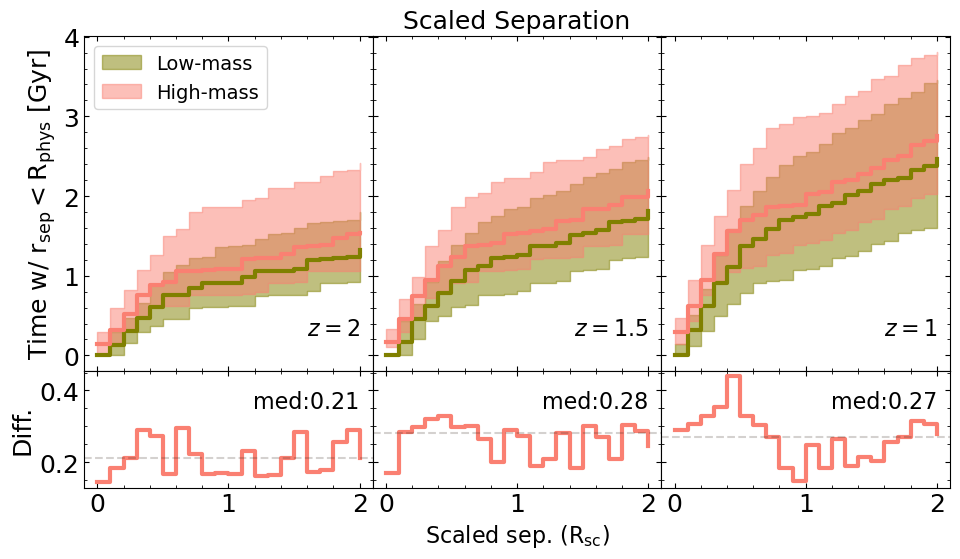

In [45]:


fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex='col', 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,0.35],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,330,10)

for en,i in enumerate([33, 40, 50]):
    snap = i

    ##########
    # Scaled
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low[snap], convert, interp=False, scaled=True, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high[snap], convert, interp=False, scaled=True, merger_only=True, bin_array=bin_array) 

    # plot 1 - scaled LoHi
    ax[0][en].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][en].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][en].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][en].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])

    ax[0][en].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

    
    # plot 2 - difference scaled
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][en].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][en].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)

    # ax[1][1].axhline(np.mean(high_dom)) 
    ax[1][en].axhline(np.median(high_dom),color=palette['difference'],alpha=0.2,linestyle='dashed') 
    ax[1][en].text(2, 0.35, f"med:{np.median(high_dom):0.2f}", ha='right',fontsize=16)




#     ########
#     # Scaled 

    # legend
    # ax[0][0].legend(loc='upper left',fontsize=14)
    ax[0][0].legend(loc='upper left',fontsize=14)

    # column titles
#     ax[0][0].set_title("Physical Separation",fontsize=18)
    ax[0][1].set_title("Scaled Separation",fontsize=18)

    # x labels
#     ax[1][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
    ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

    # y labels
    ax[0][0].set_ylabel(r"Time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",fontsize=18)
    ax[1][0].set_ylabel("Diff.",fontsize=18)

plt.tight_layout()
# plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_diff_scale_noint.png")
plt.show()




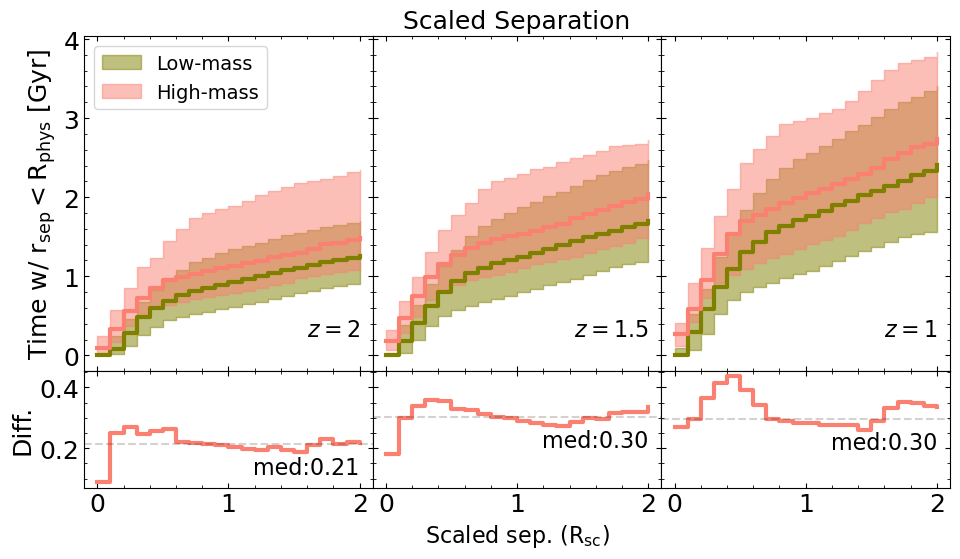

In [46]:


fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex='col', 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,0.35],
                                    'wspace': 0.0,
                                    "hspace":0.0})
z={"33":r"$z=2$","40":r"$z=1.5$","50":r"$z=1$"}
little_h = 0.6774
data_name = ["low","high"]
data_sets = [low,high]
data_sets_interp = [low_interp,high_interp]
data_label = ["Low-mass","High-mass"]
secondary_name = ["difference","difference2"]
secondary_name = ["All pairs","difference2"]
bin_array = np.arange(10,330,10)

for en,i in enumerate([33, 40, 50]):
    snap = i

    ##########
    # Scaled
    ms1, ss1, mds1, qs1, bins1 = get_manual_cumulative(low_interp[snap], convert_interp, interp=True, scaled=True, merger_only=True, bin_array=bin_array)
    ms2, ss2, mds2, qs2, bins2 = get_manual_cumulative(high_interp[snap], convert_interp, interp=True, scaled=True, merger_only=True, bin_array=bin_array) 

    # plot 1 - scaled LoHi
    ax[0][en].plot(bins1[:-1],mds1,color=palette['low'],ds='steps-post',lw=3)
    ax[0][en].fill_between(bins1[:-1],qs1[:,0],qs1[:,1],color=palette['low'],step='post',alpha=0.5,label=data_label[0])

    ax[0][en].plot(bins2[:-1],mds2,color=palette['high'],ds='steps-post',lw=3)
    ax[0][en].fill_between(bins2[:-1],qs2[:,0],qs2[:,1],color=palette['high'],step='post',alpha=0.5,label=data_label[1])

    ax[0][en].text(2, 0.25, z[str(snap)], ha='right',fontsize=16)

    
    # plot 2 - difference scaled
    low_dom = np.where( mds1-mds2 > 0, mds1-mds2, np.nan)
    high_dom = np.where( mds2-mds1 > 0, mds2-mds1, np.nan)
    ax[1][en].plot(bins1[:-1],low_dom,color=palette['low'],ds='steps-post',lw=3)
    ax[1][en].plot(bins1[:-1],high_dom,color=palette['high'],ds='steps-post',lw=3)

    # ax[1][1].axhline(np.mean(high_dom)) 
    ax[1][en].axhline(np.median(high_dom),color=palette['difference'],alpha=0.2,linestyle='dashed') 
    ax[1][en].text(2, np.median(high_dom)-0.1, f"med:{np.median(high_dom):0.2f}", ha='right',fontsize=16)


# legend
# ax[0][0].legend(loc='upper left',fontsize=14)
ax[0][0].legend(loc='upper left',fontsize=14)

# column titles
#     ax[0][0].set_title("Physical Separation",fontsize=18)
ax[0][1].set_title("Scaled Separation",fontsize=18)

# x labels
#     ax[1][0].set_xlabel(r"Physical sep. $(\rm R_{phys})$ [kpc]",fontsize=16)
ax[1][1].set_xlabel(r"Scaled sep. $(\rm R_{sc})$",fontsize=16)

# y labels
ax[0][0].set_ylabel(r"Time w/ $\rm r_{sep}< \rm R_{phys}$ [Gyr]",fontsize=18)
ax[1][0].set_ylabel("Diff.",fontsize=18)

plt.tight_layout()
plt.savefig(f"{paths.path_plots}bet-on-it/2_medtotal_diff_scale.pdf")
plt.show()




# to the grave

In [47]:
elapsed_array = np.concatenate((np.abs(np.diff(convert["Lookback Time"])),np.array([0])))
elapsed_matrix = np.tile(elapsed_array,(len(unique_low['PostInfall']),1))

In [48]:
mod_group_flag = unique_low['PostInfall'][post_infall][:,0:34]

NameError: name 'post_infall' is not defined

In [ ]:
mod_group_flag.shape

In [ ]:
is_post_infall = unique_low['PostInfall'][:,34] # need to include z=2 so it isn't ind 33
post_infall = unique_low['PostInfall'][is_post_infall]

In [ ]:
unique_low['PostInfall'][is_post_infall]

In [ ]:
is_post_infall = unique_low['PostInfall'][:,34] # need to include z=2 so it isn't ind 33
post_infall = unique_low['PostInfall'][is_post_infall]



prior_seps = unique_low['Separations'][:,0:34][post_infall][mod_group_flag]
min_mask = prior_seps > 10

corr_elapsed = elapsed_matrix[:,0:34][post_infall][mod_group_flag]

seps = prior_seps[min_mask]
elapsed = corr_elapsed[min_mask]

In [ ]:
vals, eges = np.histogram(seps,bins=np.arange(10,300,25))
plt.step(eges[:-1],vals)

plt.show()

In [ ]:
vals, eges = np.histogram(seps,bins=np.arange(10,300,25),weights=elapsed)
plt.step(eges[:-1],vals)

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for en,i in enumerate([low, high]):
    for ii, snap in enumerate([33, 40, 50]):
        orb = i[snap]
        sep_matrix = orb["Separations"]
        elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
        scales = convert['Scale'] # gives scale in same order as orbit data

        scale_matrix = np.tile(scales,(len(sep_matrix),1))
        sep_ckpcperh = sep_matrix/scale_matrix*little_h

        # array of the elapsed time with a nan value in the place of z=0
        elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
        elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

        nan_elapsed = np.isnan(elapsed_matrix)
        nan_sep = np.isnan(sep_matrix)
        zero_sep = sep_matrix == 0
        lower_sep = sep_ckpcperh > 10
        matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep

        merger_array = np.array(orb["MergeFlag"],dtype='bool')
        merge_mask = np.tile(merger_array,(100,1)).transpose()

    #     elapsed_masked = elapsed_matrix[matrix_mask]
    #     sep_masked = sep_matrix[matrix_mask]

        ## calculate histograms
        xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]


        xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

        yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

        num_mergers = sum(merger_array)
        num_pairs = len(merger_array) 
        bins_phys = np.arange(0,1000,20)
        bins_ckpch = np.arange(10,1500,20)

        phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
        phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
        comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
        comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    

        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2)
        ax[ii][en].stairs(np.cumsum(phys_all),bins_phys,color="mediumturquoise",lw=2,label='All Pairs')

#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2)
#         ax[ii][1].stairs(np.cumsum(comov_all),bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')

#         ax[ii][1].text(375,0.1,f"{z[str(snap)]}")


    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    #     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
    # #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")

    #     ax[ii].text(0,1,f"{z[str(snap)]}")
    #     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    #     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


    ax[0][0].set_title("Low Mass Pairs",fontsize=20)
    ax[0][1].set_title("High Mass Pairs",fontsize=20)

#     ax[2][0].set_xlabel("Separation [kpc]")
#     ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

#     ax[0][0].legend()
#     ax[0][1].legend()

#     ax[0][0].legend()
#     fig.suptitle("Total time with sep < S: Massive pairs")
    # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
    fig.supxlabel("Separation S [kpc]",y=0.05)
#     fig.supylabel(r"$\left< \Delta T\right>_{pair}$ where $r_{sep}<S$ [Gyr]")
#     plt.savefig(f"{paths.path_plots}big-bad/cumulative-timevssep_z.png")
plt.show()


In [ ]:
corr_elapsed[0]

In [ ]:
np.sum(np.where(prior_seps[0]>10, np.where(prior_seps[0]<50,corr_elapsed[0],False),False))

In [ ]:
ave_times_in_bin = np.sum(np.where(prior_seps>10, np.where(prior_seps<50,corr_elapsed,False),False),axis=1)

In [ ]:
np.mean(ave_times_in_bin)

In [ ]:
seps.shape

In [ ]:
plt.hist(ave_times_in_bin,bins=np.arange(0,1.5))

## test out a fit for z > 1

In [ ]:
from sklearn.linear_model import LinearRegression

mask = np.where(convert["Redshift"]>1,np.where(convert["Redshift"]<6),False)

yy = log

In [ ]:
data = low_interp[40]
convert = convert_interp

physical_seps = data["Separations Interp"]
elapsed_time = np.abs(np.diff(convert["Lookback Time Interp"]))
elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
elapsed_matrix = np.tile(elapsed_noz0,(len(physical_seps),1))
infall_arrays = np.array(np.triu(np.zeros((len(elapsed_noz0),len(elapsed_noz0)))+1),dtype='bool')
post_infall_matrix = infall_arrays[ind_in_interp[data['InfallSnapshot']]]

In [ ]:
# build masks to remove low separation objects
lower_sep = physical_seps > 10
non_nan = ~np.isnan(physical_seps)

matrix_mask = lower_sep & non_nan

merger_array = np.array(data["MergeFlag"],dtype='bool')
merge_mask = np.tile(merger_array,(len(elapsed_noz0),1)).transpose()
    

In [ ]:
sep_matrix = data["Separations Interp"]

In [ ]:
sep_matrix[0][200:250]

In [ ]:
septype = "Separations"
    
bin_array=np.arange(0,420,20)


septype = septype+" Interp"

sep_matrix = data[septype]
    

In [ ]:
sep_matrix[0][200:250]

In [ ]:
sep_masked = np.where((matrix_mask&merge_mask&post_infall_matrix),sep_matrix,0)

In [ ]:
matrix_mask[0][2800:2850]

In [ ]:
merge_mask[0][2800:2850]

In [ ]:
post_infall_matrix[0][2800:2850]

In [ ]:
low[40]['InfallSnapshot'][0]

In [ ]:
data['InfallSnapshot'][0]

In [ ]:
ind_in_interp[38]

In [ ]:
sep_masked[0][2800:2850]

In [ ]:
## calculate histograms
sep_masked = np.where((matrix_mask&merge_mask&post_infall_matrix),sep_matrix,0)
print(sep_masked[0])
mean, std = [], []
med,qs = [], []

# for i in range(len(bin_array)-1):
#     # give the elapsed matrix array where the separations are between 10-bin[i+1]
#     what = np.where(sep_masked < bin_array[i+1], elapsed_matrix,False)
#     sums = np.sum(what,axis=1)
#     print(sums)
#     mean.append(np.mean(sums))
#     std.append(np.std(sums))
#     med.append(np.median(sums))
#     qs.append(np.quantile(sums,np.array([0.25,0.75])))
# #         print(bin_array[i],bin_array[i+1], mn, std, med, qs)
#     #     print(sums)
            
#     print(np.mean(sums), np.std(sums), np.median(sums), np.quantile(sums,np.array([0.25,0.75])))
        
        

In [ ]:
np.where(sep_masked != 0 , np.where(sep_masked < bin_array[i+1], elapsed_matrix,False), False)

In [ ]:
for i in range(len(bin_array)-1):
    what = np.where(sep_masked > 0 , np.where(sep_masked < bin_array[i+1], elapsed_matrix,False), False)
    sums = np.sum(what,axis=1)
#     mn = np.mean(sums)
#     std = np.std(sums)
#     print(bin_array[i],bin_array[i+1], mn, std)
    print(sums)

In [ ]:
for i in range(len(bin_array)-1):
    what = np.where(sep_masked >bin_array[i] , np.where(sep_masked < bin_array[i+1], elapsed_matrix,False), False)
    sums = np.sum(what,axis=1)
    mn = np.mean(sums)
    std = np.std(sums)
    print(bin_array[i],bin_array[i+1], mn, std)
#     print(sums)

In [ ]:
for i in range(len(bin_array)-1):
    what = np.where(sep_masked > 0 , np.where(sep_masked < bin_array[i+1], elapsed_matrix,False), False)
    sums = np.sum(what,axis=1)
    mn = np.mean(sums)
    std = np.std(sums)
    med = np.median(sums)
    qs = np.quantile(sums,np.array([0.25,0.75]))
    print(bin_array[i],bin_array[i+1], mn, std, med, qs)
#     print(sums)

In [ ]:
for i in range(len(bin_array)-1):
    what = np.where(sep_masked > bin_array[i] , np.where(sep_masked < bin_array[i+1], elapsed_matrix,False), False)
    sums = np.sum(what,axis=1)
    mn = np.mean(sums)
    std = np.std(sums)
    med = np.median(sums)
    qs = np.quantile(sums,np.array([0.25,0.75]))
    print(bin_array[i],bin_array[i+1], mn, std, med, qs)
#     print(sums)

In [ ]:
what = np.where(sep_masked > 380 , np.where(sep_masked < 400, elapsed_matrix,False), False)
np.median(np.sum(what,axis=1))
np.quantile(np.sum(what,axis=1),np.array([0.25,0.75]))

In [ ]:
for i in range(len(bin_array)-1):
    what = np.where(sep_masked[0] != 0 , np.where(sep_masked[0] < bin_array[i+1], elapsed_matrix[0],False), False)

    print(bin_array[i],bin_array[i+1],np.sum(what))

In [ ]:
lower_low = unique_low['Separations'] > 10
upper_low = unique_low['Separations'] < 50

lower_high = unique_high['Separations'] > 10
upper_high = unique_high['Separations'] < 50

In [ ]:
# find elapsed time between snapshots & create matrix of elapsed times
times = convert['Lookback Time']
elapsed = np.concatenate((np.abs(np.diff(times)),[0]))

elapsed_low = np.where(lower_low&upper_low,elapsed,0)
elapsed_high = np.where(lower_high&upper_high,elapsed,0)

In [ ]:
total_time_low = np.sum(elapsed_low,axis=0)
ave_time_low = total_time_low/num_pairs_low

total_time_high = np.sum(elapsed_high,axis=0)
ave_time_high = total_time_high/num_pairs_high

In [ ]:
ave_time_high

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,8),sharey=False,sharex=True,
                      gridspec_kw={'wspace': 0.04,
                                    "hspace":0.0})
ax[0].scatter(convert["Redshift"][:-1],ave_time_low[:-1],label='Low mass',color="tab:cyan")
ax[0].plot(convert["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:gray")
ax[1].scatter(convert["Redshift"][:-1],ave_time_high[:-1],label='High mass',color="tab:olive")
ax[1].plot(convert["Redshift"],0.04/(1+(snap_dict["Redshift"]))**2,label=r"$C(1+z)^{-2}$",color="tab:pink")
ax[0].set_ylim(0,0.06)
# ax[1].set_ylim(0,0.02)
plt.xlim(right=6)
ax[0].legend()
ax[1].legend()
plt.xlabel("Redshift")
# plt.ylabel("Average time (per pair) spent at 10-50")
plt.show()